# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.139895,False,0.725975
1,0.441310,False,0.390722
2,2.161172,True,6.000320
3,1.156442,True,4.977580
4,0.295562,True,4.837209
...,...,...,...
995,0.534898,False,-1.545799
996,0.952158,True,4.982640
997,0.791088,False,0.698613
998,0.207293,False,0.740914


<Axes: xlabel='v0'>

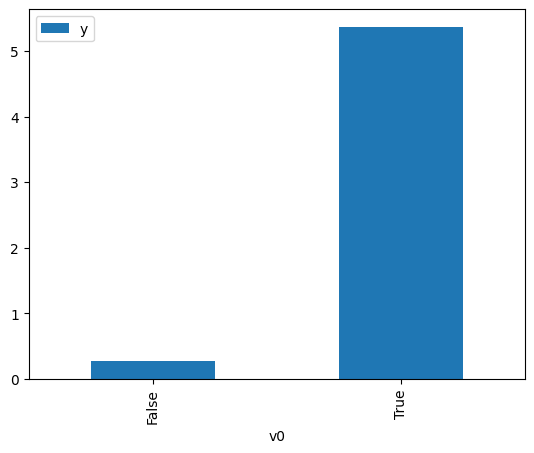

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

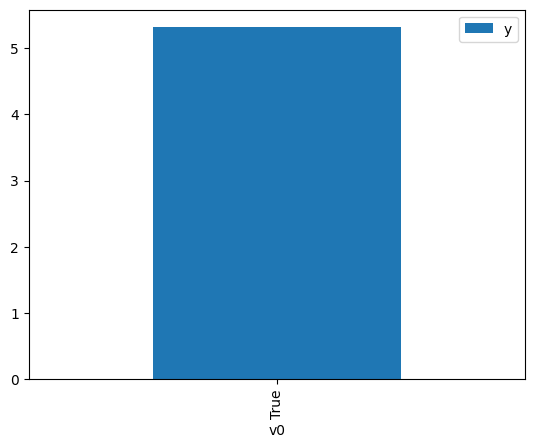

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.081241,False,-1.413455,0.867967,1.152117
1,0.627052,False,0.019487,0.239899,4.168415
2,0.101236,False,0.872251,0.445557,2.244384
3,1.673205,False,0.912117,0.046857,21.341714
4,0.685169,False,-0.064892,0.221572,4.513204
...,...,...,...,...,...
995,0.207293,False,0.740914,0.399596,2.502525
996,0.627052,False,0.019487,0.239899,4.168415
997,-1.585109,False,-0.634686,0.941513,1.062120
998,1.533579,False,1.596262,0.059273,16.871099


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.371319,True,6.164877,0.922449,1.084071
1,-0.418538,True,6.108949,0.330658,3.024274
2,1.329232,True,5.837597,0.916926,1.090601
3,1.124828,True,7.196275,0.884728,1.130291
4,0.677533,True,6.186566,0.776078,1.288530
...,...,...,...,...,...
995,1.836263,True,6.123997,0.964514,1.036791
996,1.975454,True,6.274403,0.972075,1.028728
997,1.219331,True,4.988036,0.900783,1.110145
998,0.352054,True,5.244182,0.660258,1.514558


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.179e+04
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:03:58   Log-Likelihood:                         -1358.6
No. Observations:                1000   AIC:                                      2721.
Df Residuals:                     998   BIC:                                      2731.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4366      0.036     12.099      0.000       0.366       0.507
x2             5.0210      0.051     98.277      0.000       4.921       5.121
==============================================================================
Omnibus:                        4.176   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.377
Skew:                          -0.093   Prob(JB):                        0.112
Kurtosis:                       3.266   Cond. No.                         2.66
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""